- Test the robustness of findings under different high-risk group sizes: network=10^{-2,-1,1}; half-life=2 day; network of 10^5 nodes
- Reproduce Fig.4 in the paper 

In [1]:
import simsom.utils as utils
import numpy as np
import pandas as pd
import os
import glob

## Helpers

In [2]:
def get_agg_metric(
    df,
    group_key=["base_name"],
    new_col_prefix="baseline",
    metrics=[
        "quality",
        "illegal_frac",
        "unique_illegal_frac",
        "illegal_count",
        "unique_illegal_count",
    ],
    retain_keys=["illegal_prob"],
):
    """
    Return a df where the columns of interest are aggregated by mean and std & renamed (prefix with a phrase)
    new_col_prefix (str): the prefix to append to aggregated cols
    """
    if any(i not in df.columns for i in retain_keys):
        raise ValueError(
            "retain_keys, e.g., `illegal_prob` column not found in the dataframe. This is needed as a dummy column to count the number of observations."
        )
    for metric in metrics:
        df[f"{metric}_std"] = df[metric]
        df = df.rename(columns={metric: f"{metric}_mean"})

    # aggregate (by mean or std)
    agg = dict()
    for col in retain_keys:
        if col == "illegal_prob":
            agg[col] = "count"
        else:
            agg[col] = "first"
    for metric in metrics:
        agg[f"{metric}_mean"] = "mean"
        agg[f"{metric}_std"] = "std"
    try:
        agg_df = df.groupby(group_key).agg(agg).reset_index()
        # rename aggregated cols with the prefix
        agg_cols = [f"{metric}_mean" for metric in metrics] + [
            f"{metric}_std" for metric in metrics
        ]
        rename_dict = {col: f"{new_col_prefix}_{col}" for col in agg_cols}
        rename_dict["illegal_prob"] = f"{new_col_prefix}_no_observations"
        agg_df = agg_df[agg_cols + group_key + retain_keys].rename(columns=rename_dict)
    except Exception as e:
        print(e)
        raise ValueError(
            "Unable to groupby or rename col, most likely the specified group_key or retain_cols don't exist."
        )
    return agg_df


def get_delay_from_name(string):
    # 4_0.01__diff_true -> 4
    delay = string.split("__")[0].split("_")[0]
    if delay != "b":
        return float(delay)
    else:
        return -1

# Helpers 
## Format violin plot

In [3]:
import seaborn as sns

# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax,
    palette=BLUEPALETTE,
    n=1,
    pointsize=200,
    edgecolor="white",
    multicolor=True,
    linewidth=1.5,
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(linewidth)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

## Extract network from name

In [4]:
import re


def extract_float(input_str):
    # Define the regular expression pattern to match the float
    pattern = r"[a-zA-Z0-9]_(\d+(\.\d+)?)__diff_true"

    # Search for the pattern in the input string
    match = re.search(pattern, input_str)

    # If a match is found, extract the float part
    if match:
        return float(match.group(1))
    else:
        raise ValueError("The input string does not match the expected format")


# Example usage
input_str1 = "1_1__diff_true"
input_str2 = "b_10__diff_true"

extracted_float1 = extract_float(input_str1)
extracted_float2 = extract_float(input_str2)

print(extracted_float1)  # Output: 0.002
print(extracted_float2)  # Output: 0.002

1.0
10.0


## Bonferroni correction

In [5]:
def bonferroni_correction(p_value, n_comparisons):
    """
    Perform Bonferroni correction on a given p-value for multiple comparisons.
    Parameters:
    -----------
    - p_value (float): The original p-value.
    - n_comparisons (int): The number of comparisons being made.
    Returns:
    -----------
    - float: The Bonferroni corrected p-value.
    """
    bonferroni_corrected_p_value = p_value * n_comparisons
    # Ensure the corrected p-value is not greater than 1
    bonferroni_corrected_p_value = min(1.0, bonferroni_corrected_p_value)
    return bonferroni_corrected_p_value

In [6]:
def get_corrected_p(plot_data, focal_col="illegal_prob", values=None, sig_level=0.05):
    # Return a dataframe with corrected p-values for all pairs of probabilities in the plot data
    from scipy.stats import mannwhitneyu

    results = []
    # option to pass in a list of values to compare (instead of all unique values)
    if values is None:
        probs = sorted(plot_data[focal_col].dropna().unique())
    else:
        probs = values
    pairs = [
        (probs[i], probs[j])
        for i in range(len(probs))
        for j in range(i + 1, len(probs))
    ]
    for pair in pairs:
        pop1 = plot_data[plot_data[focal_col] == pair[0]]["pct_change"]
        pop2 = plot_data[plot_data[focal_col] == pair[1]]["pct_change"]
        U, p = mannwhitneyu(pop1, pop2, method="exact")
        results.append({"pair": pair, "U": U, "p": p})
    stats = pd.DataFrame(results)
    stats["corrected_p"] = stats["p"].apply(
        lambda x: bonferroni_correction(x, len(pairs))
    )
    print("p-values:", stats)
    significant_pairs = stats[stats.corrected_p < sig_level]["pair"].tolist()
    print(f"Significant pairs (p<{sig_level}): ", significant_pairs)
    print(f"Min p-val: {min(stats['corrected_p'])}")
    return stats, significant_pairs

## Annotation 

In [7]:
# Define the annotation legend
annotation_legend = {
    (0.05, 1.00): "ns",
    (0.01, 0.05): "ns",
    (0.001, 0.01): "*",
    (0.0001, 0.001): "**",
    (0.0, 0.0001): "***",
}


# Function to get the annotation based on p-value
def get_annotation(p_value):
    for (lower, upper), annotation in annotation_legend.items():
        if lower < p_value <= upper:
            return annotation
    return "Invalid p-value"


# Function to add annotations
def add_annotation(ax, x1, x2, y, text):
    ax.plot([x1, x1, x2, x2], [y, y + 1, y + 1, y], lw=1.5, color="k")
    ax.text(
        (x1 + x2) * 0.5, y + 1, text, ha="center", va="bottom", color="k", fontsize=12
    )

# Prevalence: Read data

## Synthetic

In [8]:
# Directory containing experiment results
ABS_PATH = "/N/u/baotruon/BigRed200/carisma/experiments/20250112_synthetic_net"
fpaths = glob.glob(f"{ABS_PATH}/prevalence*/*.parquet")
dfs = []
for idx, fpath in enumerate(fpaths):
    if idx % 5 == 0:
        print(f"Processing {idx}/{len(fpaths)}")
    raw = pd.read_parquet(fpath, engine="pyarrow")
    dfs += [raw]
synthetic = pd.concat(dfs, ignore_index=True)
synthetic["network"] = ["synthetic"] * len(synthetic)

Processing 0/11
Processing 5/11
Processing 10/11


In [9]:
synthetic

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,fpath,moderation_half_life,quality,graph_gml,no_steps,network
0,0.018729,0.011701,2811,13,/N/project/simsom/carisma/20250116_synthetic_n...,0.0625,-1.0,/N/project/simsom/carisma/20241224_synthetic_n...,442,synthetic
1,0.007069,0.005464,1061,6,/N/project/simsom/carisma/20250116_synthetic_n...,2.0000,-1.0,/N/project/simsom/carisma/20241224_synthetic_n...,210,synthetic
2,0.006290,0.007853,944,9,/N/project/simsom/carisma/20250116_synthetic_n...,8.0000,-1.0,/N/project/simsom/carisma/20241224_synthetic_n...,3493,synthetic
3,0.009594,0.008681,1440,10,/N/project/simsom/carisma/20250116_synthetic_n...,0.0625,-1.0,/N/project/simsom/carisma/20241224_synthetic_n...,1231,synthetic
4,0.008208,0.010998,1230,13,/N/project/simsom/carisma/20250116_synthetic_n...,2.0000,-1.0,/N/project/simsom/carisma/20241224_synthetic_n...,1386,synthetic
...,...,...,...,...,...,...,...,...,...,...
76,0.000898,0.001855,134,2,/N/project/simsom/carisma/20241224_synthetic_n...,0.5000,-1.0,/N/project/simsom/carisma/20241224_synthetic_n...,752,synthetic
77,0.005823,0.008272,873,9,/N/project/simsom/carisma/20241224_synthetic_n...,4.0000,-1.0,/N/project/simsom/carisma/20241224_synthetic_n...,242,synthetic
78,0.003466,0.011618,519,14,/N/project/simsom/carisma/20241224_synthetic_n...,2.0000,-1.0,/N/project/simsom/carisma/20241224_synthetic_n...,3239,synthetic
79,0.005963,0.009001,895,10,/N/project/simsom/carisma/20241224_synthetic_n...,128.0000,-1.0,/N/project/simsom/carisma/20241224_synthetic_n...,2123,synthetic


In [10]:
synthetic["base_name"] = synthetic["fpath"].apply(lambda x: os.path.basename(x))
synthetic["illegal_prob"] = synthetic["base_name"].apply(extract_float)
synthetic.groupby("base_name")["fpath"].count()


base_name
0_0.01__diff_true.json.gz      5
10_0.01__diff_true.json.gz     5
11_0.01__diff_true.json.gz     5
1_0.01__diff_true.json.gz     11
2_0.01__diff_true.json.gz      5
3_0.01__diff_true.json.gz     11
4_0.01__diff_true.json.gz      5
5_0.01__diff_true.json.gz      5
6_0.01__diff_true.json.gz      5
7_0.01__diff_true.json.gz      5
8_0.01__diff_true.json.gz      5
9_0.01__diff_true.json.gz      4
b_0.01__diff_true.json.gz     10
Name: fpath, dtype: int64

In [11]:
synthetic["illegal_prob"].unique()

array([0.01])

## Empirical

In [12]:
# Directory containing experiment results
ABS_PATH = "/N/u/baotruon/BigRed200/carisma/experiments/20241126_main_results"
fpaths = glob.glob(f"{ABS_PATH}/prevalence*main_results/*.parquet")
dfs = []
for idx, fpath in enumerate(fpaths):
    if idx % 5 == 0:
        print(f"Processing {idx}/{len(fpaths)}")
    raw = pd.read_parquet(fpath, engine="pyarrow")
    dfs += [raw]

empirical = pd.concat(dfs, ignore_index=True)
empirical = empirical.drop_duplicates()
empirical["network"] = ["empirical"] * len(empirical)

Processing 0/44
Processing 5/44
Processing 10/44
Processing 15/44
Processing 20/44
Processing 25/44
Processing 30/44
Processing 35/44
Processing 40/44


In [13]:
empirical["base_name"] = empirical["fpath"].apply(lambda x: os.path.basename(x))
# empirical.groupby("base_name")["fpath"].count()
empirical["illegal_prob"] = empirical["base_name"].apply(extract_float)
empirical.groupby("illegal_prob")['fpath'].count()

illegal_prob
0.01    756
Name: fpath, dtype: int64

In [14]:
# what is the illegal_prob used in baseline experiments?
empirical[empirical['base_name'].str.contains('b_')]['illegal_prob'].unique()

array([0.01])

In [15]:
# empirical = empirical[empirical["illegal_prob"] == 0.01]
combined = pd.concat([synthetic, empirical], ignore_index=True)

In [16]:
combined.groupby("illegal_prob")['fpath'].count()

illegal_prob
0.01    837
Name: fpath, dtype: int64

In [17]:
# combined[combined["illegal_prob"]==0]['base_name'].unique()

In [18]:
# combined["base_name"] = combined["fpath"].apply(lambda x: os.path.basename(x))
# combined["illegal_prob"] = combined["base_name"].apply(extract_float)
print("illegal prob values:", combined["illegal_prob"].unique())
print("len combined data: ", len(combined))
data = combined[~combined["unique_illegal_frac"].isna()]
print("len combined data (after removing nans): ", len(data))

illegal prob values: [0.01]
len combined data:  837
len combined data (after removing nans):  837


In [19]:
data["half_life"] = data.apply(
    lambda row: -1 if "b_" in row["base_name"] else row["moderation_half_life"], axis=1
)
retain_cols = [
    "network",
    "illegal_frac",
    "unique_illegal_frac",
    "illegal_count",
    "unique_illegal_count",
    "illegal_prob",
    "half_life",
]
data = data[retain_cols]
data.head()

,network,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life
0,synthetic,0.018729,0.011701,2811,13,0.01,-1.0
1,synthetic,0.007069,0.005464,1061,6,0.01,2.0
2,synthetic,0.006290,0.007853,944,9,0.01,8.0
3,synthetic,0.009594,0.008681,1440,10,0.01,-1.0
4,synthetic,0.008208,0.010998,1230,13,0.01,2.0


# Count number of observations for each param

## Baseline

In [20]:
# Count the number of rows for each combination of 'half_life' and 'illegal_content_probability'
data[data.half_life == -1].groupby("illegal_prob").size()

illegal_prob
0.01    60
dtype: int64

## Non-baseline

In [21]:
# Count the number of rows for each combination of 'moderation_half_life' and 'illegal_content_probability'
row_counts = (
    data[data.half_life != -1]
    .groupby(["network", "half_life"])
    .size()
    .reset_index(name="count")
)

# Display the result
row_counts.sort_values(by=["network"])

,network,half_life,count
0,empirical,0.0625,50
13,empirical,512.0000,50
11,empirical,128.0000,50
10,empirical,64.0000,50
9,empirical,32.0000,50
8,empirical,16.0000,50
7,empirical,8.0000,50
12,empirical,256.0000,50
5,empirical,2.0000,50
4,empirical,1.0000,54


# Pct change: metric-baseline_median / (baseline_median)
Merge scatter data with avg baseline

In [22]:
# create a new column since illegal_prob is used as a dummy column
# data["illegal_content_probability"] = data["illegal_prob"]
baseline = data[data.half_life == -1]
# baseline['network_type']=  baseline['network']
baseline = get_agg_metric(
    baseline,
    group_key=["network", "illegal_prob"],
    new_col_prefix="baseline",
    metrics=[
        "illegal_frac",
        "unique_illegal_frac",
    ],
    retain_keys=["half_life"],
)

/tmp/ipykernel_60022/2605465826.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{metric}_std"] = df[metric]


In [23]:
baseline

,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,network,baseline_no_observations,half_life
0,0.009655,0.010314,0.004352,0.001338,empirical,0.01,-1.0
1,0.011183,0.011929,0.004376,0.002688,synthetic,0.01,-1.0


## Get pct change

In [24]:
res = data[data.half_life != -1]
baseline = baseline.drop(columns=["half_life"])
baseline = baseline.dropna(subset="baseline_illegal_frac_std")
results = res.merge(baseline, on="network", how="left")

In [25]:
results.head()

,network,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations
0,synthetic,0.007069,0.005464,1061,6,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01
1,synthetic,0.006290,0.007853,944,9,0.01,8.0,0.011183,0.011929,0.004376,0.002688,0.01
2,synthetic,0.008208,0.010998,1230,13,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01
3,synthetic,0.010707,0.012585,1607,13,0.01,8.0,0.011183,0.011929,0.004376,0.002688,0.01
4,synthetic,0.006518,0.006082,978,7,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01


In [26]:
results = results[~results.unique_illegal_frac.isna()]

In [27]:
metric = "unique_illegal_frac"
results["pct_change"] = (
    (results[f"baseline_{metric}_mean"] - results[metric])
    / results[f"baseline_{metric}_mean"]
    * 100
)

In [28]:
results

,network,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,pct_change
0,synthetic,0.007069,0.005464,1061,6,0.01,2.0000,0.011183,0.011929,0.004376,0.002688,0.01,54.189959
1,synthetic,0.006290,0.007853,944,9,0.01,8.0000,0.011183,0.011929,0.004376,0.002688,0.01,34.163056
2,synthetic,0.008208,0.010998,1230,13,0.01,2.0000,0.011183,0.011929,0.004376,0.002688,0.01,7.798572
3,synthetic,0.010707,0.012585,1607,13,0.01,8.0000,0.011183,0.011929,0.004376,0.002688,0.01,-5.500569
4,synthetic,0.006518,0.006082,978,7,0.01,2.0000,0.011183,0.011929,0.004376,0.002688,0.01,49.015931
...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,empirical,0.008325,0.010069,1248,54,0.01,128.0000,0.009655,0.010314,0.004352,0.001338,0.01,2.372723
773,empirical,0.009322,0.008220,1397,44,0.01,8.0000,0.009655,0.010314,0.004352,0.001338,0.01,20.303244
774,empirical,0.007542,0.007018,1128,39,0.01,8.0000,0.009655,0.010314,0.004352,0.001338,0.01,31.952931
775,empirical,0.003617,0.003217,537,17,0.01,1.0000,0.009655,0.010314,0.004352,0.001338,0.01,68.805982


# Statistical significance: pct change 

In [29]:
# !pip install statsmodels
from statannotations.stats.ComparisonsCorrection import ComparisonsCorrection

## Filter tau=2 (remove outliers)

In [30]:
from scipy.stats import mannwhitneyu

stat_res = []
probs = sorted(results.network.dropna().unique())
pairs = [
    (probs[i], probs[j]) for i in range(len(probs)) for j in range(i + 1, len(probs))
]
pairs

[('empirical', 'synthetic')]

In [31]:
focal = results[results.half_life == 2]
focal = focal[focal["pct_change"] > 0]
em = focal[focal.network == "empirical"].sample(10, random_state=15)
syn = focal[focal.network == "synthetic"]
focal = pd.concat([em, syn], ignore_index=True)

In [32]:
em

,network,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,pct_change
569,empirical,0.004885,0.006591,732,36,0.01,2.0,0.009655,0.010314,0.004352,0.001338,0.01,36.094827
597,empirical,0.005125,0.005606,766,29,0.01,2.0,0.009655,0.010314,0.004352,0.001338,0.01,45.644846
664,empirical,0.004994,0.003568,746,19,0.01,2.0,0.009655,0.010314,0.004352,0.001338,0.01,65.404533
444,empirical,0.005576,0.004142,834,22,0.01,2.0,0.009655,0.010314,0.004352,0.001338,0.01,59.836496
611,empirical,0.006568,0.006752,982,36,0.01,2.0,0.009655,0.010314,0.004352,0.001338,0.01,34.536748
683,empirical,0.005634,0.003307,843,18,0.01,2.0,0.009655,0.010314,0.004352,0.001338,0.01,67.935876
123,empirical,0.005122,0.005484,766,31,0.01,2.0,0.009655,0.010314,0.004352,0.001338,0.01,46.829846
542,empirical,0.007164,0.003879,1073,20,0.01,2.0,0.009655,0.010314,0.004352,0.001338,0.01,62.390090
500,empirical,0.004517,0.004283,677,22,0.01,2.0,0.009655,0.010314,0.004352,0.001338,0.01,58.476082
583,empirical,0.005054,0.006838,753,36,0.01,2.0,0.009655,0.010314,0.004352,0.001338,0.01,33.703693


In [33]:
syn

,network,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,pct_change
0,synthetic,0.007069,0.005464,1061,6,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01,54.189959
2,synthetic,0.008208,0.010998,1230,13,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01,7.798572
4,synthetic,0.006518,0.006082,978,7,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01,49.015931
6,synthetic,0.003087,0.004496,462,5,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01,62.305587
8,synthetic,0.003698,0.005682,552,7,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01,52.367968
10,synthetic,0.005459,0.008094,819,9,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01,32.150056
20,synthetic,0.006197,0.007699,929,9,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01,35.458394
32,synthetic,0.004461,0.006140,669,7,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01,48.523980
44,synthetic,0.008014,0.008319,1201,10,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01,30.255927
56,synthetic,0.004457,0.006563,668,8,0.01,2.0,0.011183,0.011929,0.004376,0.002688,0.01,44.982854


In [34]:
stat_res = []
for pair in pairs:
    # randomly choose 10 records of empirical
    pop1 = focal[focal.network == pair[0]]["pct_change"]
    pop2 = focal[focal.network == pair[1]]["pct_change"]
    U, p = mannwhitneyu(pop1, pop2, method="exact")
    stat_res.append({"pair": pair, "U": U, "p": p})
df = pd.DataFrame(stat_res)

In [35]:
df

,pair,U,p
0,"(empirical, synthetic)",78.0,0.114466


In [36]:
df["corrected_p"] = df["p"].apply(lambda x: bonferroni_correction(x, len(pairs)))
df

,pair,U,p,corrected_p
0,"(empirical, synthetic)",78.0,0.114466,0.114466


# Plot pctchange 

pctchange = treatment - avg_control/avg_control


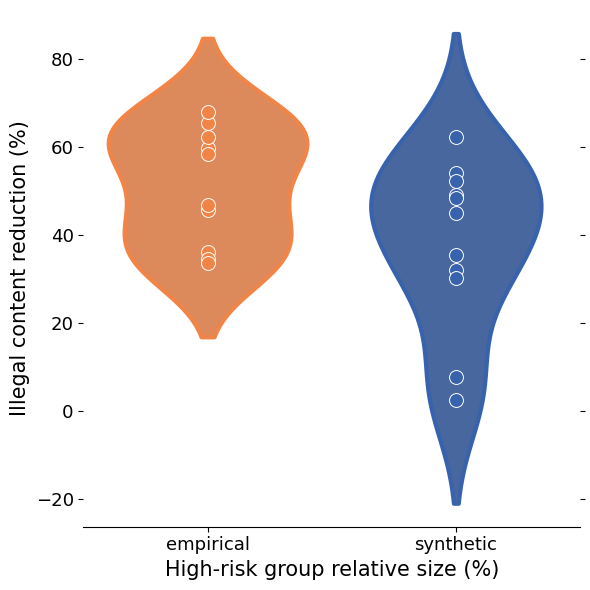

In [37]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import FuncFormatter

PLOT_DIR = "plots_check"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"pct_change_network_tau2")

plot_data = focal
fig, ax = plt.subplots(figsize=(6, 6))

# Get unique probabilities and sort them
probs = sorted(focal.network.unique())

# Create the violin plot
violin = sns.violinplot(
    data=plot_data,
    x="network",
    y="pct_change",
    order=probs,
    inner="point",
    palette=BLUEPALETTE,
)

violin.set_ylabel("Illegal content reduction (%)")
violin.set_xlabel("High-risk group relative size (%)")
patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
point_violinplot(ax, palette=BLUEPALETTE, n=len(probs), pointsize=100, linewidth=0.7)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
sns.despine(top=True, left=True, bottom=False)

# ax.set_ylim(0, 100)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf", dpi=300)
    fig.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Save tau=2 data to an object

In [38]:
tau2_res = plot_data

## Filter tau=8

In [39]:
from scipy.stats import mannwhitneyu

stat_res = []
probs = sorted(results.network.dropna().unique())
pairs = [
    (probs[i], probs[j]) for i in range(len(probs)) for j in range(i + 1, len(probs))
]
pairs

[('empirical', 'synthetic')]

## Remove outlier. Check this again

In [40]:
focal = results[results.half_life == 8]
focal = focal[focal["pct_change"] > 0]
em = focal[focal.network == "empirical"].sample(10, random_state=15)
syn = focal[focal.network == "synthetic"]
focal = pd.concat([em, syn], ignore_index=True)

In [41]:
em

,network,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,pct_change
320,empirical,0.006469,0.005545,969,30,0.01,8.0,0.009655,0.010314,0.004352,0.001338,0.01,46.233817
293,empirical,0.007273,0.007948,1090,43,0.01,8.0,0.009655,0.010314,0.004352,0.001338,0.01,22.935138
668,empirical,0.008655,0.007888,1297,44,0.01,8.0,0.009655,0.010314,0.004352,0.001338,0.01,23.517975
725,empirical,0.007852,0.007505,1176,40,0.01,8.0,0.009655,0.010314,0.004352,0.001338,0.01,27.235760
125,empirical,0.007511,0.008397,1125,46,0.01,8.0,0.009655,0.010314,0.004352,0.001338,0.01,18.581890
585,empirical,0.006201,0.009019,929,48,0.01,8.0,0.009655,0.010314,0.004352,0.001338,0.01,12.551658
731,empirical,0.005964,0.006152,894,35,0.01,8.0,0.009655,0.010314,0.004352,0.001338,0.01,40.349056
516,empirical,0.006010,0.008004,901,43,0.01,8.0,0.009655,0.010314,0.004352,0.001338,0.01,22.390003
571,empirical,0.007044,0.007665,1055,39,0.01,8.0,0.009655,0.010314,0.004352,0.001338,0.01,25.680511
460,empirical,0.009489,0.006519,1422,36,0.01,8.0,0.009655,0.010314,0.004352,0.001338,0.01,36.789196


In [42]:
stat_res = []
for pair in pairs:
    # randomly choose 10 records of empirical
    pop1 = focal[focal.network == pair[0]]["pct_change"]
    pop2 = focal[focal.network == pair[1]]["pct_change"]
    U, p = mannwhitneyu(pop1, pop2, method="exact")
    stat_res.append({"pair": pair, "U": U, "p": p})
df = pd.DataFrame(stat_res)

In [43]:
df

,pair,U,p
0,"(empirical, synthetic)",33.0,0.217563


In [44]:
df["corrected_p"] = df["p"].apply(lambda x: bonferroni_correction(x, len(pairs)))
df

,pair,U,p,corrected_p
0,"(empirical, synthetic)",33.0,0.217563,0.217563


# Plot pctchange 

pctchange = treatment - avg_control/avg_control


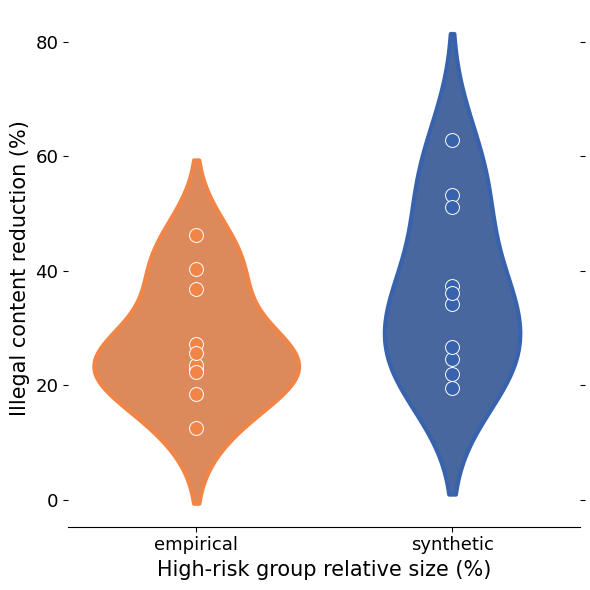

In [45]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import FuncFormatter

PLOT_DIR = "plots_check"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"pct_change_network_tau8")

plot_data = focal
fig, ax = plt.subplots(figsize=(6, 6))

# Get unique probabilities and sort them
probs = sorted(focal.network.unique())

# Create the violin plot
violin = sns.violinplot(
    data=plot_data,
    x="network",
    y="pct_change",
    order=probs,
    inner="point",
    palette=BLUEPALETTE,
)

violin.set_ylabel("Illegal content reduction (%)")
violin.set_xlabel("High-risk group relative size (%)")
patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
point_violinplot(ax, palette=BLUEPALETTE, n=len(probs), pointsize=100, linewidth=0.7)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
sns.despine(top=True, left=True, bottom=False)

# ax.set_ylim(0, 100)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf", dpi=300)
    fig.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Save tau=8 data to an object

In [46]:
tau8_res = plot_data

# Plot in panel

In [47]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import FuncFormatter

plt.style.use("stylesheet.mplstyle")
PLOT_DIR = "plots_check"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)
fpath = os.path.join(PLOT_DIR, f"pct_change_syntheticnet")

In [48]:
# plot_data['network_label'] = plot_data['network'].apply(lambda x: 'Synthetic' if x == 'synthetic' else 'Empirical')

Probs:  ['empirical', 'synthetic']
p-values:                      pair     U         p  corrected_p
0  (empirical, synthetic)  78.0  0.114466     0.114466
Significant pairs (p<0.001):  []
Min p-val: 0.11446602932671045
p-values:                      pair     U         p  corrected_p
0  (empirical, synthetic)  33.0  0.217563     0.217563
Significant pairs (p<0.001):  []
Min p-val: 0.21756262313537858


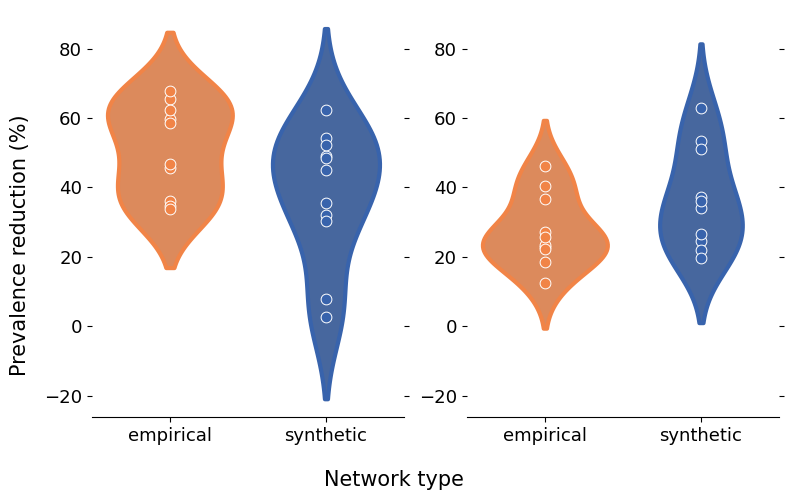

In [49]:
sig_level = 0.001
plot_dfs = [tau2_res, tau8_res]
y_label = "Prevalence reduction (%)"
x_label = "Network type"
fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)

print("Probs: ", probs)
for idx, plot_data in enumerate(plot_dfs):
    # print(f"** Plot {y_labels[idx]} **")
    ax = axs[idx]
    # Create the violin plot
    violin = sns.violinplot(
        ax=ax,
        data=plot_data,
        x="network",
        y="pct_change",
        order=probs,
        inner="point",
        palette=BLUEPALETTE,
    )
    violin.set_xlabel("")
    violin.set_ylabel("")

    patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
    point_violinplot(ax, palette=BLUEPALETTE, n=len(probs), pointsize=60, linewidth=0.7)
    ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
    sns.despine(top=True, left=True, bottom=False)

    ## TEST SIGNIFICANCE
    stats, significant_pairs = get_corrected_p(
        plot_data, focal_col="network", sig_level=sig_level
    )
    significant_pairs = [
        i for i in significant_pairs if i[0] in probs and i[1] in probs
    ]
    # Add annotations for significant pairs
    y_max = plot_data["pct_change"].max()
    for x1, x2 in significant_pairs:
        stat, p = stats[stats["pair"] == (x1, x2)][["U", "corrected_p"]].values[0]
        if p < sig_level:
            y = y_max + 5  # Adjust the y position for the annotation
            add_annotation(ax, probs.index(x1), probs.index(x2), y, get_annotation(p))
            print(f"Pair ( {x1}, {x2} ): p-value: {p:.2e}")
            y_max += 10  # Increment y_max for the next annotation

    # ax.set_ylim(0, 100)
fig.supylabel(y_label, fontsize=15)
fig.supxlabel(x_label, fontsize=15)
# Saving
plt.tight_layout()

if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()